# Flight Price Prediction #
## Introduction ##
This Notebook tries to find an answer to the question "What is the best time to book a flight?".
The dataset used in this notebook is provided by Prof. Dr. Martin Spott and Manu Mutthatu.
It contains flight data from 2019 for the following routes:
-   London Stansted and Berlin Schönefeld
-   London Stansted and Frankfurt

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import math

## Get the data ##

In [2]:
# read in the data
df_train = pd.read_csv('train_set.csv')
df_test = pd.read_csv('test_set.csv')

## Explore the data (Data Exploration) ##

In [3]:
# make a copy of the data
df_train_copy = df_train.copy()
df_test_copy = df_test.copy()

# check the data
df_train_copy.head()

,index,Request_Date,Flight_Date,Departure_hour,flight_unique_id,route_abb,Price_In_Eur,min_future_price_in_Eur,buy
0,1,2019-06-03T11:00:00Z,2019-06-05,19,2019-06-05 FR 146,SXF-STN,208.07,259.07,1
1,2,2019-06-03T23:00:00Z,2019-06-05,19,2019-06-05 FR 146,SXF-STN,259.07,259.07,1
2,3,2019-06-04T11:00:00Z,2019-06-05,19,2019-06-05 FR 146,SXF-STN,259.07,259.07,1
3,4,2019-06-04T23:00:00Z,2019-06-05,19,2019-06-05 FR 146,SXF-STN,259.07,259.07,1
4,5,2019-06-03T11:00:00Z,2019-06-05,21,2019-06-05 FR 147,STN-SXF,143.86,251.72,1


we can see that the data contains the following columns:
-   index: index of the row
-   request_date: date when the request was made
-   flight_date: date when the flight took place
-   departure_hour: hour when the flight departed
-   flight_unique_id: unique id for each flight
-   route_abb: abbreviation of the route
-   price_in_eur: price of the flight in euro
-   min_future_price_in_euro: minimum price of the flight in euro for all future request dates
-   buy: 1 if the flight should be bought, 0 if not (TODO: check if this is correct)

In [ ]:
# check the number of rows and columns
df_train_copy.shape

we can see that the data contains 83624 rows and 9 columns.

In [4]:
# check the data types
df_train_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83624 entries, 0 to 83623
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   index                    83624 non-null  int64  
 1   Request_Date             83624 non-null  object 
 2   Flight_Date              83624 non-null  object 
 3   Departure_hour           83624 non-null  int64  
 4   flight_unique_id         83624 non-null  object 
 5   route_abb                83624 non-null  object 
 6   Price_In_Eur             83624 non-null  float64
 7   min_future_price_in_Eur  83624 non-null  float64
 8   buy                      83624 non-null  int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 5.7+ MB


we can see that the data types are correct, except for the date columns. We will deal with that later.

In [7]:
# check if there are any missing values
df_train_copy.isnull().sum()

index                      0
Request_Date               0
Flight_Date                0
Departure_hour             0
flight_unique_id           0
route_abb                  0
Price_In_Eur               0
min_future_price_in_Eur    0
buy                        0
dtype: int64

You can see that there are no missing values in the data.

In [15]:
# check the noise in the data
df_train_copy.describe()

,index,Departure_hour,Price_In_Eur,min_future_price_in_Eur,buy
count,83624.000000,83624.000000,83624.000000,83624.000000,83624.000000
mean,41812.500000,12.969889,71.965080,56.593014,0.223835
std,24140.313792,6.177936,54.788483,46.126909,0.416815
min,1.000000,6.000000,8.990000,8.990000,0.000000
25%,20906.750000,7.000000,32.770000,22.270000,0.000000
50%,41812.500000,10.000000,55.080000,41.890000,0.000000
75%,62718.250000,19.000000,91.790000,73.430000,0.000000
max,83624.000000,22.000000,372.960000,311.090000,1.000000


count    83624.000000
mean        71.965080
std         54.788483
min          8.990000
25%         32.770000
50%         55.080000
75%         91.790000
max        372.960000
Name: Price_In_Eur, dtype: float64


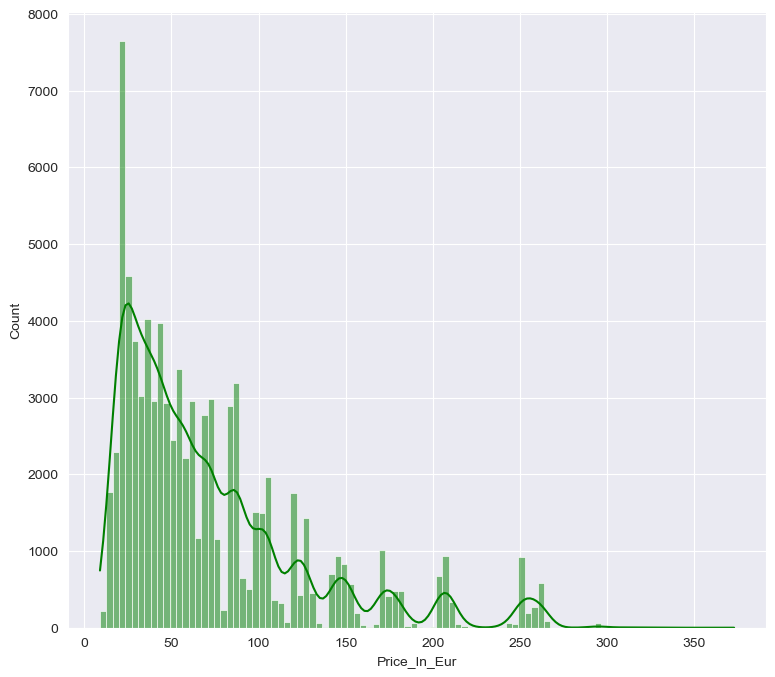

In [23]:
# check the distribution of Price in Euro
plt.figure(figsize=(9, 8))
sns.histplot(df_train_copy['Price_In_Eur'], color='g', bins=100, kde=True);

The prices seem to be quite evenly distributed. There are some outliers in higher prices, but they are not too far away from the rest of the data.

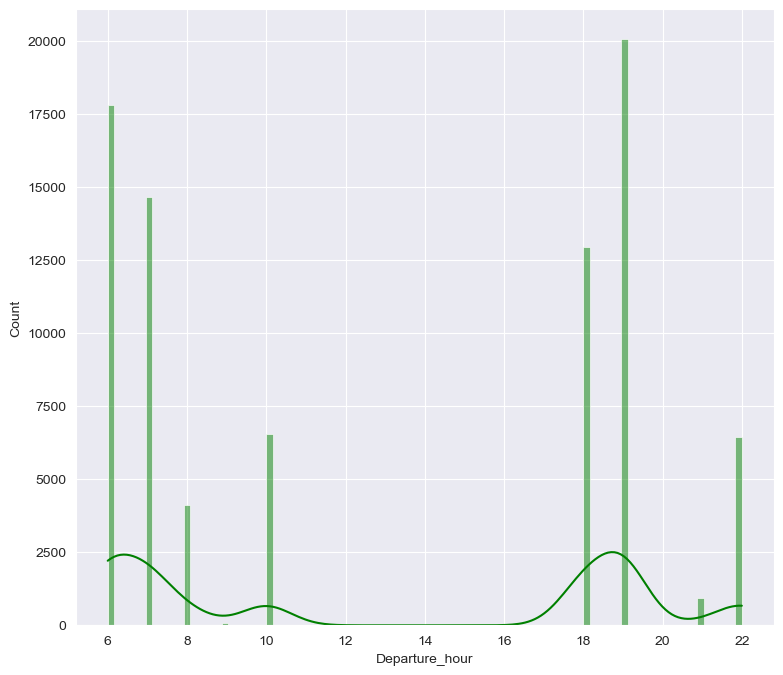

In [25]:
# check the distribution of Departure hour
plt.figure(figsize=(9, 8))
sns.histplot(df_train_copy['Departure_hour'], color='g', bins=100, kde=True);

In [29]:
# check the amounts of data with Departure hour between 12 and 16
df_train_copy[(df_train_copy['Departure_hour'] >= 12) & (df_train_copy['Departure_hour'] <= 16)].shape[0]

0

The earliest flights depart at 6, the latest at 22. Most flights seem to depart in the morning or in the evening. There are no flights departing in the afternoon between 12 and 16.

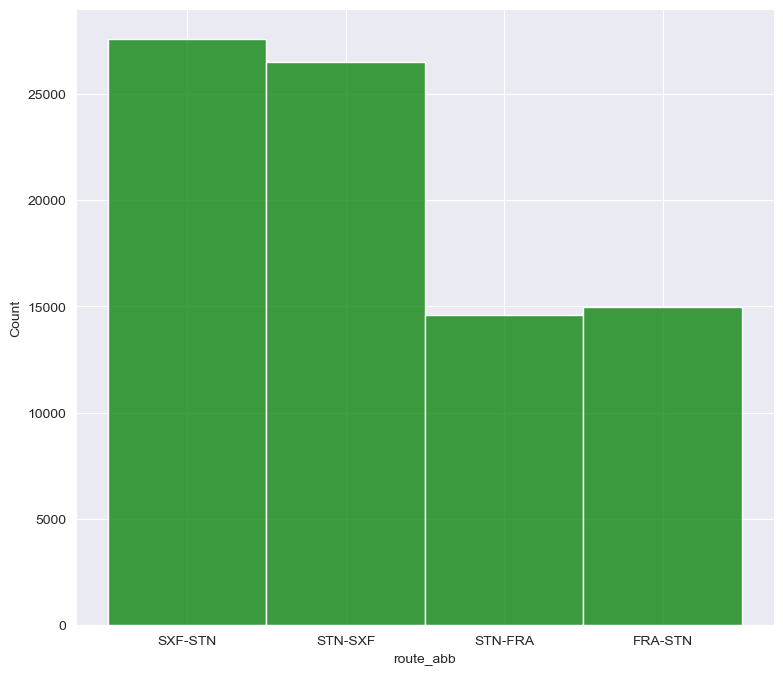

In [32]:
# check the distribution of route abb
plt.figure(figsize=(9, 8))
sns.histplot(df_train_copy['route_abb'], color='g', bins=100);

The data contains 2 routes: SXF-STN and STN-FRA additionally for both of those routes there are flights in both directions. There are a little more than 10000 more flights from STN-SXF/SXF-STN than from FRA-STN/STN-FRA.

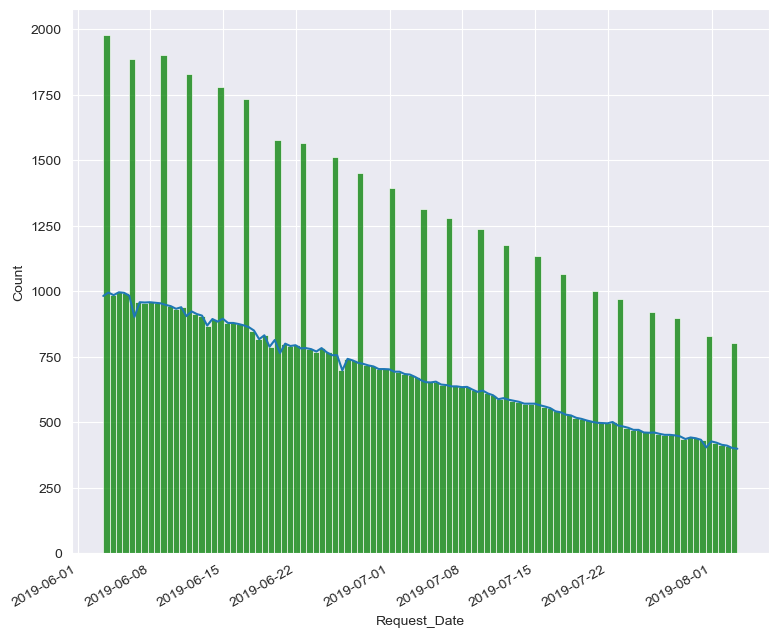

In [70]:
# check the distribution of the request date
# convert the request date to datetime
df_train_copy['Request_Date'] = pd.to_datetime(df_train_copy['Request_Date'])

plt.figure(figsize=(9, 8))
sns.histplot(df_train_copy['Request_Date'], color='g', bins=100);

# make a more useful plot for the request date
df_train_copy['Request_Date'].value_counts().plot(figsize=(9, 8));

In [38]:
# check for outliers in request date
df_train_copy[df_train_copy['Request_Date'] < '2019-01-01'].shape[0]

0

The data contains requests from 2019-01-01 to (TODO). There are no outliers in the request date.

In [66]:
# check the last request date for each flight
df_train_copy.groupby('flight_unique_id')['Request_Date'].max()

index
1       2019-06-03 11:00:00+00:00
2       2019-06-03 23:00:00+00:00
3       2019-06-04 11:00:00+00:00
4       2019-06-04 23:00:00+00:00
5       2019-06-03 11:00:00+00:00
                   ...           
83620   2019-08-01 11:00:00+00:00
83621   2019-08-01 23:00:00+00:00
83622   2019-08-02 11:00:00+00:00
83623   2019-08-02 23:00:00+00:00
83624   2019-08-03 11:00:00+00:00
Name: Request_Date, Length: 83624, dtype: datetime64[ns, UTC]

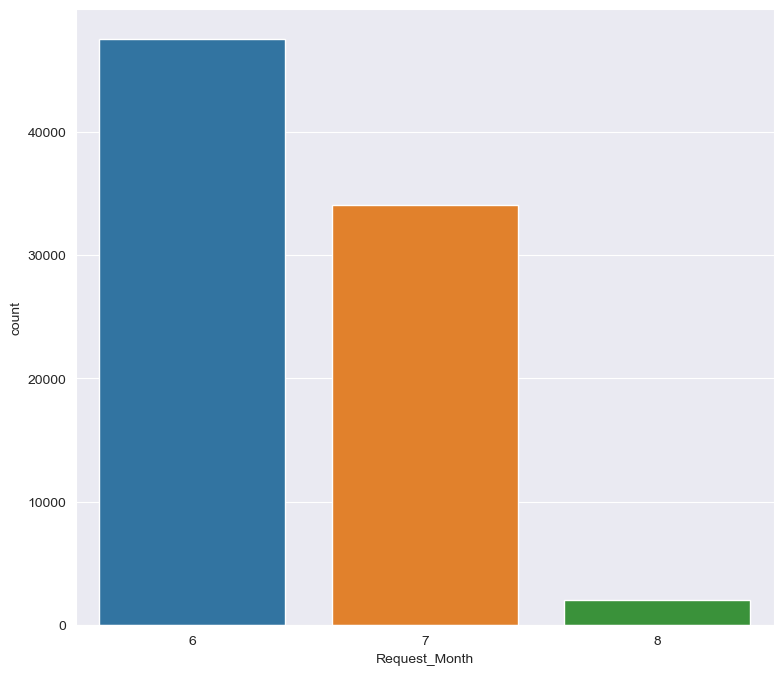

In [60]:
# Extract the month from the request date
df_train_copy['Request_Month'] = df_train_copy['Request_Date'].dt.month

# plot the request month
plt.figure(figsize=(9, 8))
sns.countplot(x='Request_Month', data=df_train_copy);

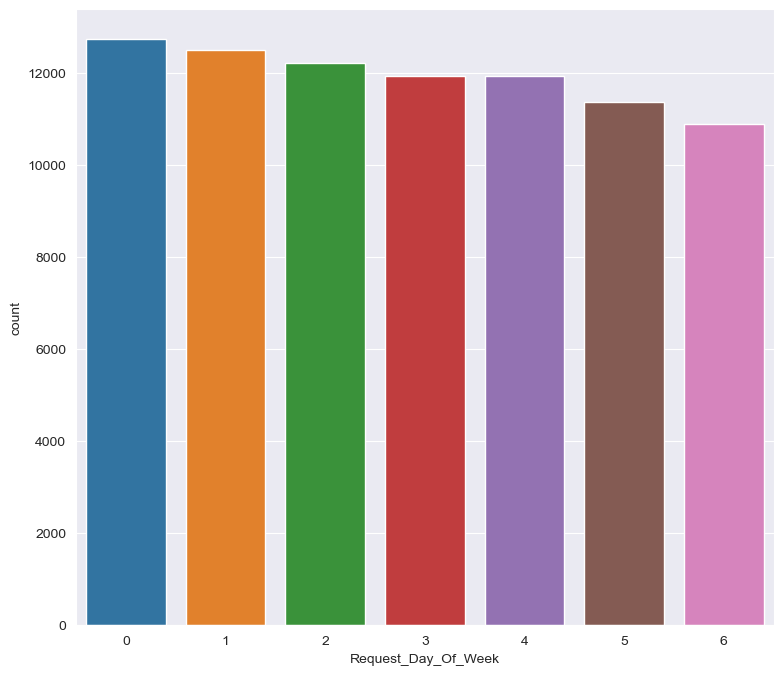

In [61]:
# Extract the day of the week from the request date
df_train_copy['Request_Day_Of_Week'] = df_train_copy['Request_Date'].dt.dayofweek

# plot the request day of the week
plt.figure(figsize=(9, 8))
sns.countplot(x='Request_Day_Of_Week', data=df_train_copy);

The data only contains requests of the months 6, 7 and 8, meaning June, July and August. The Month with the most requests is June, a little less in July and only a few in August. There are nearly the same amount of requests on each day of the week.

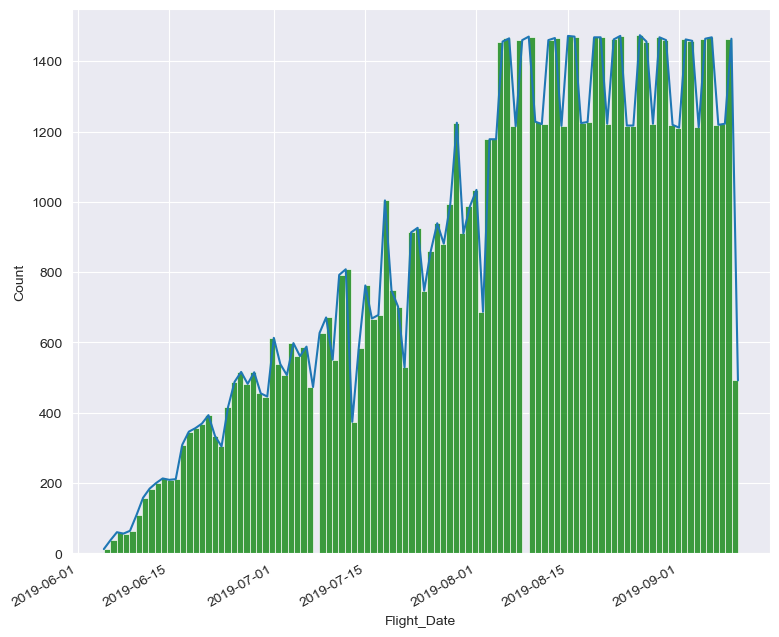

In [68]:
# check the distribution of flight date
# convert the flight date to datetime
df_train_copy['Flight_Date'] = pd.to_datetime(df_train_copy['Flight_Date'])

plt.figure(figsize=(9, 8))
sns.histplot(df_train_copy['Flight_Date'], color='g', bins=100);

# make a more useful plot for the flight date
df_train_copy['Flight_Date'].value_counts().plot(figsize=(9, 8));

In [79]:
# check data types of flight date and request date
print(df_train_copy['Flight_Date'].dtype)
print(df_train_copy['Request_Date'].dtype)

# df_train_copy['Request_Date'] = df_train_copy['Request_Date'].dt.tz_convert(None)


# check dates, where the flight date is before the request date
df_train_copy[df_train_copy['Flight_Date'] < df_train_copy['Request_Date']]

datetime64[ns]
datetime64[ns]


,index,Request_Date,Flight_Date,Departure_hour,flight_unique_id,route_abb,Price_In_Eur,min_future_price_in_Eur,buy,Request_Month,Request_Day_Of_Week


There are no Flights where the flight date is before the request date.

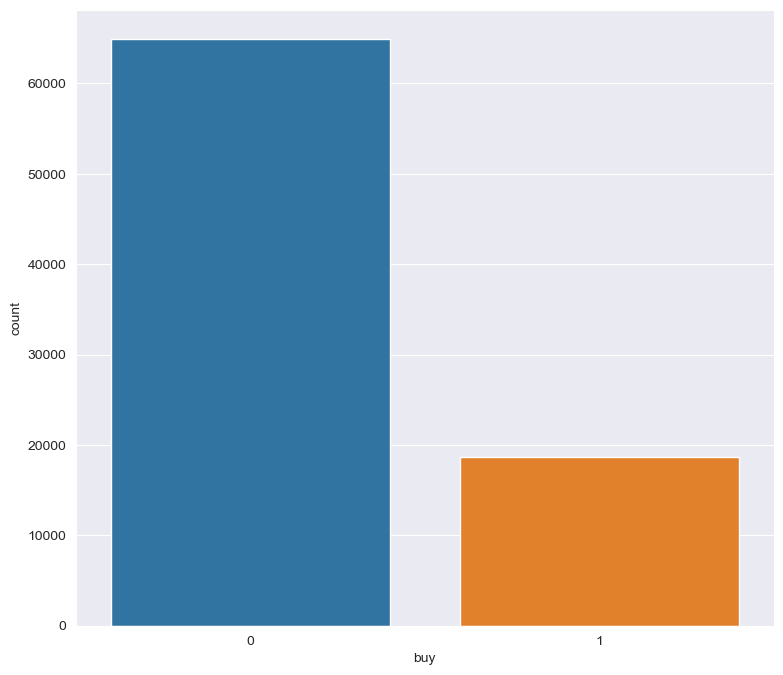

In [82]:
# check the distribution of buy
plt.figure(figsize=(9, 8))
sns.countplot(x='buy', data=df_train_copy);

There are a lot more flights that should not be bought than flights that should be bought.